# Exploratory Data Analysis

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             1000 non-null   object 
 1   sensor_id             1000 non-null   object 
 2   vehicle_speed (km/h)  1000 non-null   int64  
 3   latitude              1000 non-null   float64
 4   longitude             1000 non-null   float64
 5   traffic_pattern       1000 non-null   object 
 6   incident_report       768 non-null    object 
 7   accident_hotspot      1000 non-null   int64  
 8   event_type            1000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB
None

Missing Values:
timestamp                 0
sensor_id                 0
vehicle_speed (km/h)      0
latitude                  0
longitude                 0
traffic_pattern           0
incident_report         232
accident_hotspot          0
event_type 

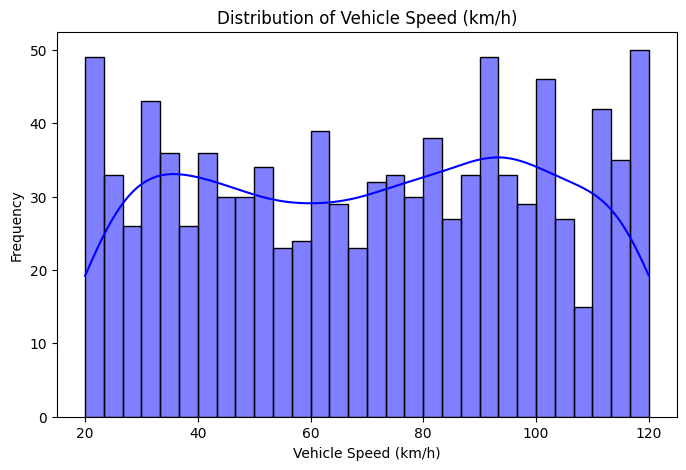

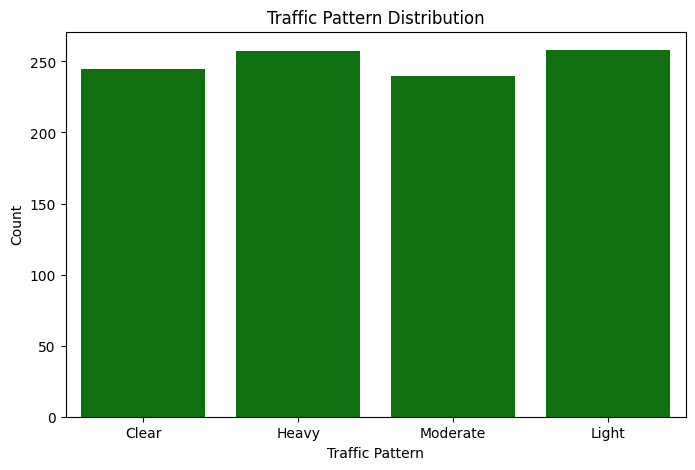

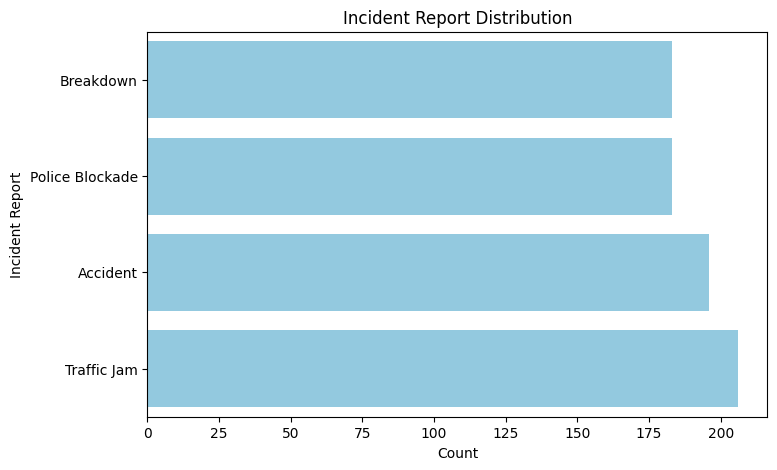

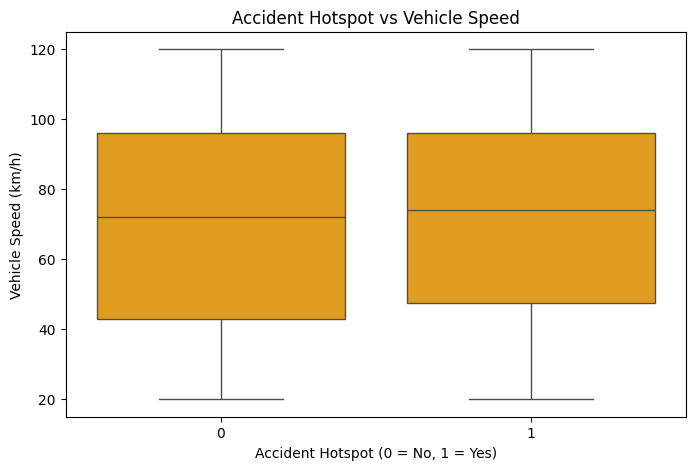

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'iot_data.csv'
data = pd.read_csv(file_path)

# General Information
print("Dataset Info:")
print(data.info())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Summary statistics for numeric columns
numeric_summary = data.describe()
print("\nSummary Statistics for Numeric Columns:")
print(numeric_summary)

# Frequency distribution of categorical columns
categorical_summary = data.select_dtypes(include='object').nunique()
print("\nUnique Values in Categorical Columns:")
print(categorical_summary)

# Correlation matrix for numeric columns
# Select only numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


# Visualization 1: Distribution of Vehicle Speed
plt.figure(figsize=(8, 5))
sns.histplot(data['vehicle_speed (km/h)'], bins=30, kde=True, color='blue')
plt.title('Distribution of Vehicle Speed (km/h)')
plt.xlabel('Vehicle Speed (km/h)')
plt.ylabel('Frequency')
plt.show()
# Visualization 2: Traffic Pattern Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='traffic_pattern', color='green')  # Updated
plt.title('Traffic Pattern Distribution')
plt.xlabel('Traffic Pattern')
plt.ylabel('Count')
plt.show()

# Visualization 3: Incident Report Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, y='incident_report', color='skyblue')  # Updated
plt.title('Incident Report Distribution')
plt.xlabel('Count')
plt.ylabel('Incident Report')
plt.show()


# Visualization 4: Accident Hotspot vs Vehicle Speed
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='accident_hotspot', y='vehicle_speed (km/h)', color='orange')  # Use 'color' instead of 'palette'
plt.title('Accident Hotspot vs Vehicle Speed')
plt.xlabel('Accident Hotspot (0 = No, 1 = Yes)')
plt.ylabel('Vehicle Speed (km/h)')
plt.show()


# Logistic Regression Model

Class Mapping: {'Accident': 0, 'Congestion': 1, 'Normal': 2}
Accuracy: 35.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.69      0.48        67
           1       0.23      0.07      0.11        70
           2       0.37      0.30      0.33        63

    accuracy                           0.35       200
   macro avg       0.32      0.35      0.31       200
weighted avg       0.32      0.35      0.30       200



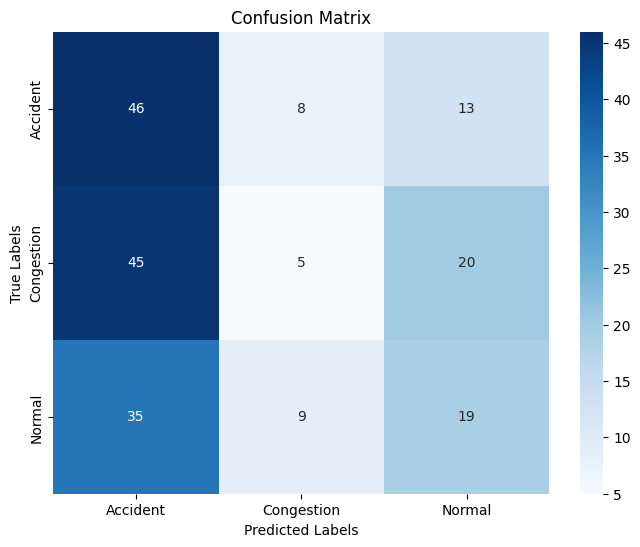

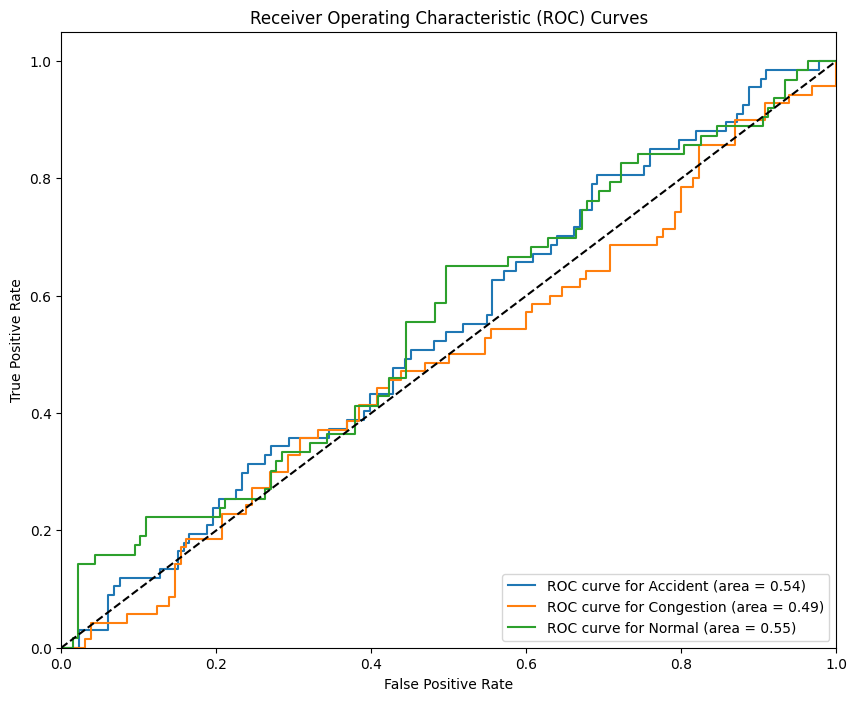

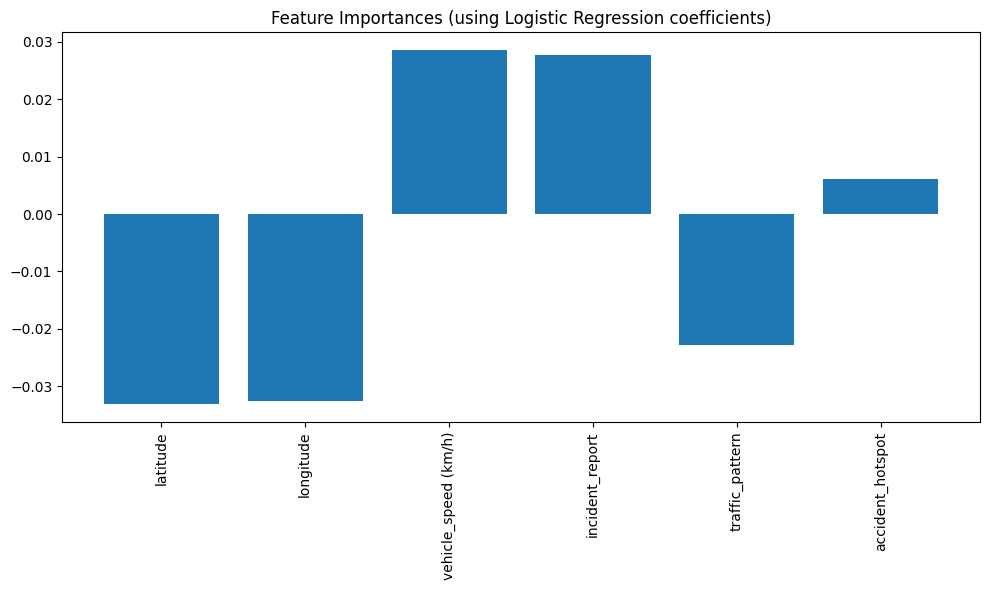

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Load the dataset
file_path = "iot_data.csv"  # Update the file path if needed
iot_data = pd.read_csv(file_path)

# Select features and target variable
X = iot_data.drop(columns=['event_type', 'timestamp', 'sensor_id'])  # Drop non-relevant columns
y = iot_data['event_type']

# Handle categorical features (traffic_pattern, incident_report)
categorical_columns = ['traffic_pattern', 'incident_report']
encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[['vehicle_speed (km/h)', 'latitude', 'longitude']] = scaler.fit_transform(
    X[['vehicle_speed (km/h)', 'latitude', 'longitude']]
)

# Encode target variable (y) to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform y into numeric labels

# Print class mapping for reference
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_encoded = log_reg.predict(X_test)

# Decode predictions back to original labels for interpretability
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
classification_rep = classification_report(y_test, y_pred_encoded)
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC for each class
n_classes = len(label_encoder.classes_)
y_test_binarized = pd.get_dummies(y_test)  # One-hot encode the test labels
y_pred_proba = log_reg.predict_proba(X_test)  # Predicted probabilities

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized.iloc[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (Using coefficients from Logistic Regression)
coefficients = log_reg.coef_[0]
indices = np.argsort(np.abs(coefficients))[::-1]  # Sort by absolute value to get feature importance

features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (using Logistic Regression coefficients)")
plt.bar(range(X.shape[1]), coefficients[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


# Logistic Regression Model Validation

In [4]:
import random

# Model Validation: Randomly select a row and classify accident severity
random_index = random.randint(0, X_test.shape[0] - 1)  # Get a random index from the test set
random_row = X_test.iloc[[random_index]]  # Select the random row as a DataFrame

# Make prediction for the selected row
random_prediction_encoded = log_reg.predict(random_row)  # Predict the class label using Logistic Regression
random_prediction = label_encoder.inverse_transform(random_prediction_encoded)  # Decode to original class label

# Print the predicted severity
print(f"Random Row Index: {random_index}")
print(f"Predicted Accident Severity: {random_prediction[0]}")
print(f"Actual Accident Severity: {label_encoder.inverse_transform([y_test[random_index]])[0]}")


Random Row Index: 170
Predicted Accident Severity: Normal
Actual Accident Severity: Normal


# Decision Tree Model

Class Mapping: {'Accident': 0, 'Congestion': 1, 'Normal': 2}
Accuracy: 34.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.34      0.32        67
           1       0.38      0.36      0.37        70
           2       0.33      0.32      0.33        63

    accuracy                           0.34       200
   macro avg       0.34      0.34      0.34       200
weighted avg       0.34      0.34      0.34       200



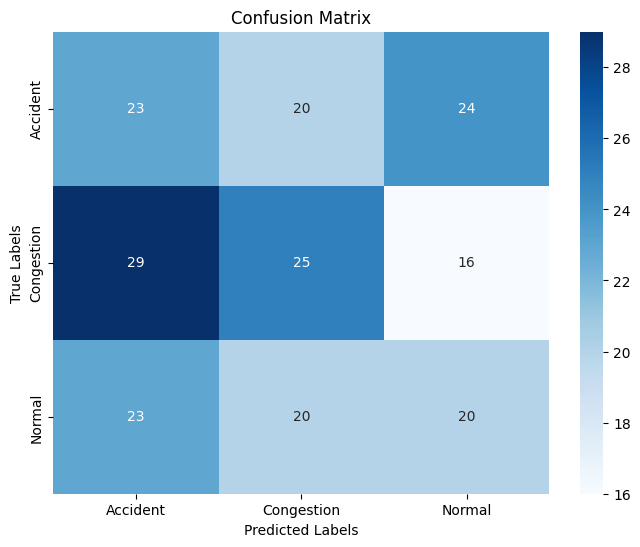

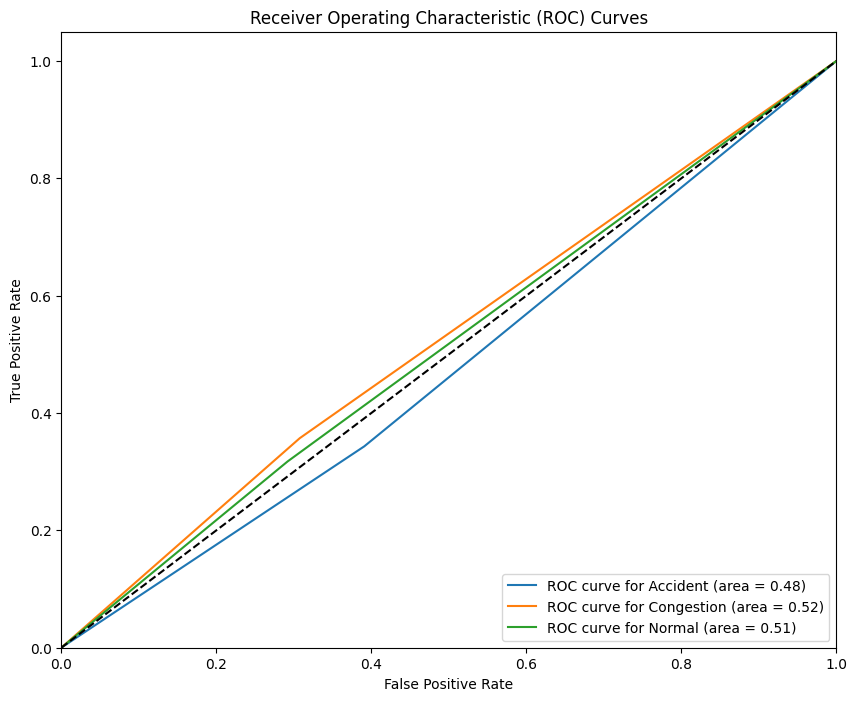

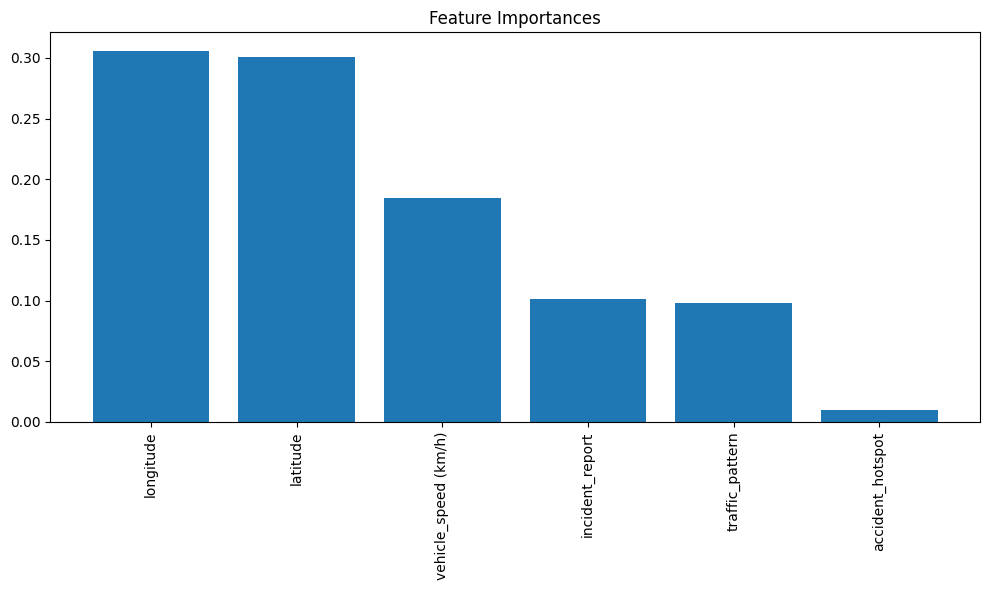

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Load the dataset
file_path = "iot_data.csv"  # Update the file path if needed
iot_data = pd.read_csv(file_path)

# Select features and target variable
X = iot_data.drop(columns=['event_type', 'timestamp', 'sensor_id'])  # Drop non-relevant columns
y = iot_data['event_type']

# Handle categorical features (traffic_pattern, incident_report)
categorical_columns = ['traffic_pattern', 'incident_report']
encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[['vehicle_speed (km/h)', 'latitude', 'longitude']] = scaler.fit_transform(
    X[['vehicle_speed (km/h)', 'latitude', 'longitude']]
)

# Encode target variable (y) to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform y into numeric labels

# Print class mapping for reference
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Make predictions
y_pred_encoded = dt_clf.predict(X_test)

# Decode predictions back to original labels for interpretability
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
classification_rep = classification_report(y_test, y_pred_encoded)
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC for each class
n_classes = len(label_encoder.classes_)
y_test_binarized = pd.get_dummies(y_test)  # One-hot encode the test labels
y_pred_proba = dt_clf.predict_proba(X_test)  # Predicted probabilities

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized.iloc[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
importances = dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


# Decision Tree Model Validation

In [6]:
import random

# Model Validation: Randomly select a row and classify accident severity
random_index = random.randint(0, X_test.shape[0] - 1)  # Get a random index from the test set
random_row = X_test.iloc[random_index]  # Select the random row

# Convert the Series to a DataFrame to retain feature names
random_row = random_row.to_frame().T  # Convert to DataFrame (transpose to make it 1 row)

# Make prediction for the selected row using Decision Tree model
random_prediction_encoded = dt_clf.predict(random_row)  # Predict the class label
random_prediction = label_encoder.inverse_transform(random_prediction_encoded)  # Decode to original class label

# Print the predicted severity
print(f"Random Row Index: {random_index}")
print(f"Predicted Accident Severity: {random_prediction[0]}")
print(f"Actual Accident Severity: {label_encoder.inverse_transform([y_test[random_index]])[0]}")


Random Row Index: 24
Predicted Accident Severity: Congestion
Actual Accident Severity: Congestion


# Random Forest Model

Accuracy: 0.34
F1 Score: 0.34041536820654605
Classification Report:
               precision    recall  f1-score   support

    Accident       0.30      0.36      0.33        67
  Congestion       0.33      0.30      0.32        70
      Normal       0.40      0.37      0.38        63

    accuracy                           0.34       200
   macro avg       0.34      0.34      0.34       200
weighted avg       0.34      0.34      0.34       200



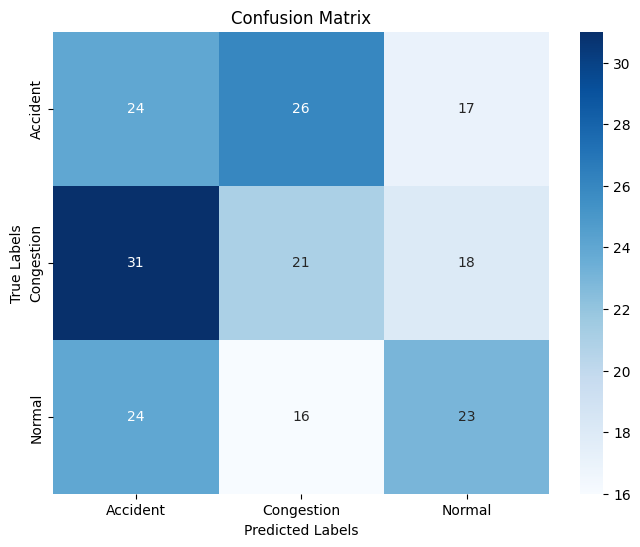

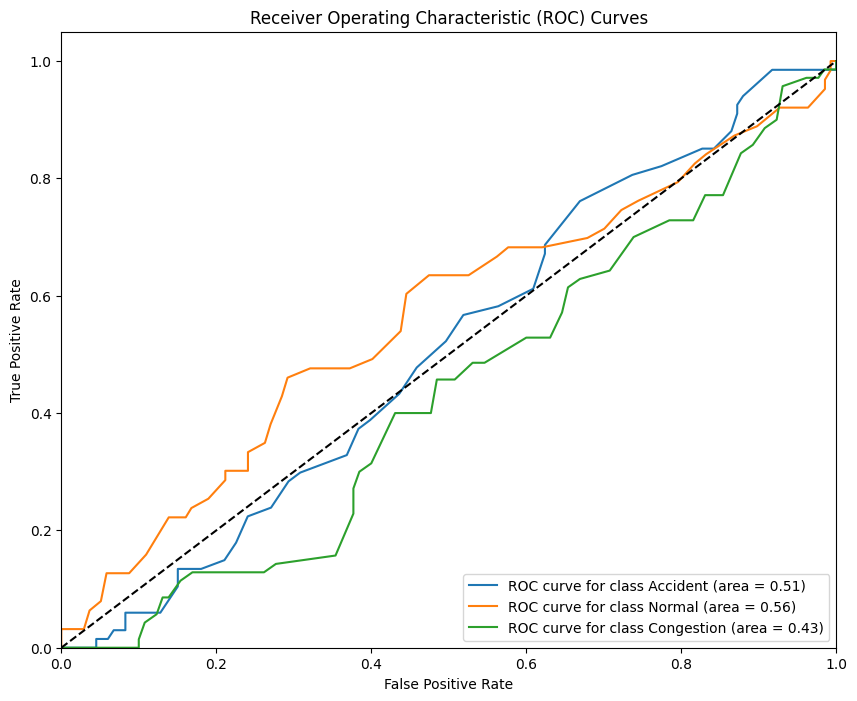

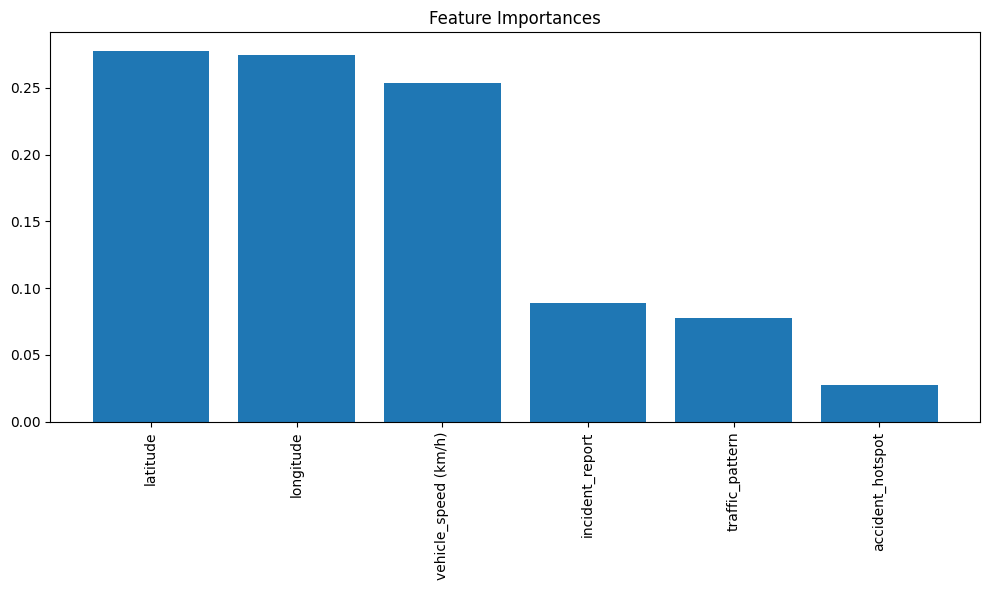

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# Load the dataset
file_path = "iot_data.csv"
iot_data = pd.read_csv(file_path)

# Select features and target variable
X = iot_data.drop(columns=['event_type', 'timestamp', 'sensor_id'])  # Drop non-relevant columns
y = iot_data['event_type']

# Handle categorical features (traffic_pattern, incident_report)
categorical_columns = ['traffic_pattern', 'incident_report']
encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[['vehicle_speed (km/h)', 'latitude', 'longitude']] = scaler.fit_transform(
    X[['vehicle_speed (km/h)', 'latitude', 'longitude']]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Binarize the output for ROC curve (one-vs-rest)
classes = y.unique()
y_binarized = label_binarize(y, classes=classes)
n_classes = y_binarized.shape[1]

rf_ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_ovr.fit(X_train, label_binarize(y_train, classes=classes))
y_score = rf_ovr.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=classes)[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Random Forest Model Validation

In [8]:
import random

# Model Validation: Randomly select a row and classify accident severity
random_index = random.randint(0, X_test.shape[0] - 1)  # Get a random index from the test set
random_row = X_test.iloc[random_index]  # Select the random row

# Ensure the random row is a DataFrame with feature names
random_row_df = random_row.to_frame().T  # Convert Series to DataFrame and transpose

# Make prediction for the selected row
random_prediction = rf_clf.predict(random_row_df)  # Predict the class label

# Print the predicted severity
print(f"Random Row Index: {random_index}")
print(f"Predicted Accident Severity: {random_prediction[0]}")
print(f"Actual Accident Severity: {y_test.iloc[random_index]}")


Random Row Index: 48
Predicted Accident Severity: Accident
Actual Accident Severity: Congestion


# XG BOOST Model

Class Mapping: {'Accident': 0, 'Congestion': 1, 'Normal': 2}
Accuracy: 30.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.33      0.31        67
           1       0.29      0.30      0.30        70
           2       0.33      0.27      0.30        63

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.30      0.30      0.30       200



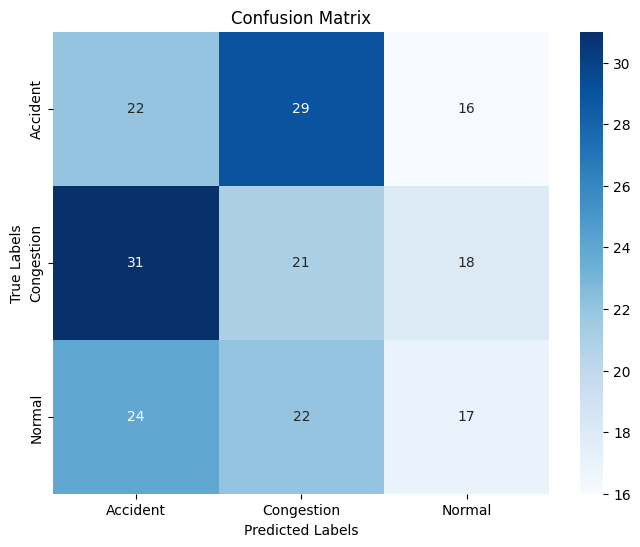

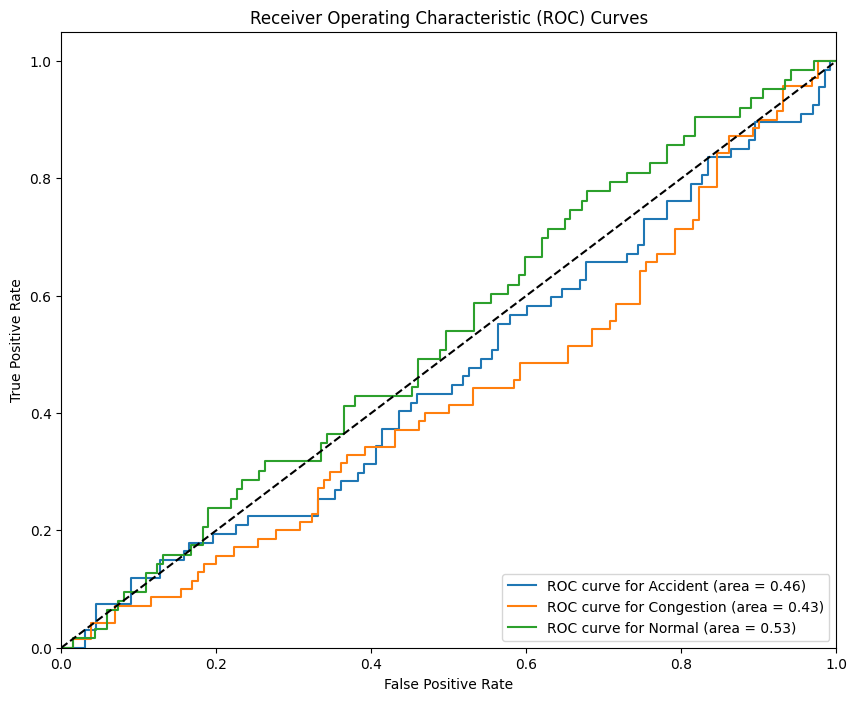

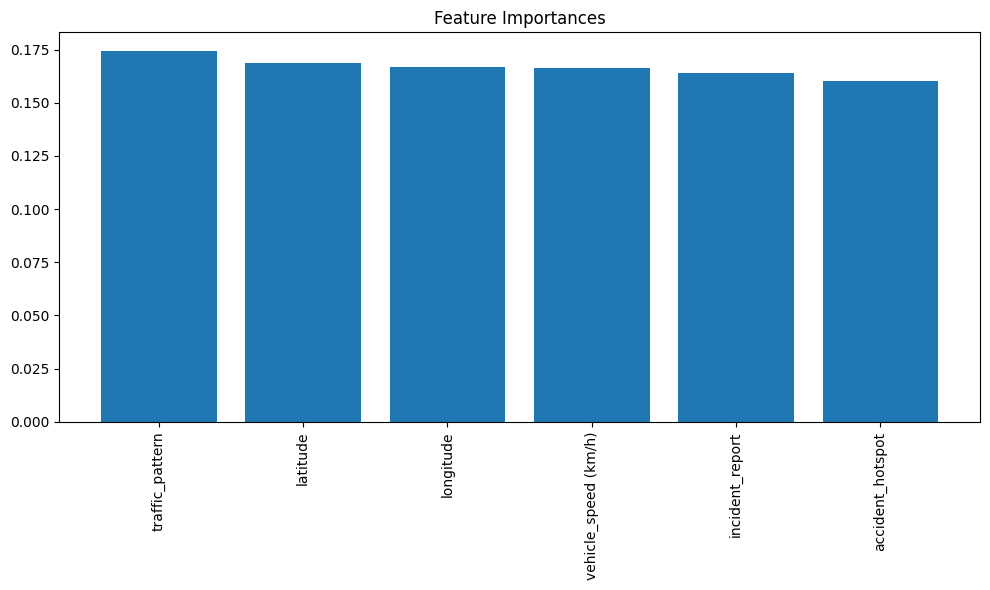

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Load the dataset
file_path = "iot_data.csv"  # Update the file path if needed
iot_data = pd.read_csv(file_path)

# Select features and target variable
X = iot_data.drop(columns=['event_type', 'timestamp', 'sensor_id'])  # Drop non-relevant columns
y = iot_data['event_type']

# Handle categorical features (traffic_pattern, incident_report)
categorical_columns = ['traffic_pattern', 'incident_report']
encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[['vehicle_speed (km/h)', 'latitude', 'longitude']] = scaler.fit_transform(
    X[['vehicle_speed (km/h)', 'latitude', 'longitude']]
)

# Encode target variable (y) to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform y into numeric labels

# Print class mapping for reference
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Classifier without the deprecated parameter
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred_encoded = xgb_clf.predict(X_test)

# Decode predictions back to original labels for interpretability
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
classification_rep = classification_report(y_test, y_pred_encoded)
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC for each class
n_classes = len(label_encoder.classes_)
y_test_binarized = pd.get_dummies(y_test)  # One-hot encode the test labels
y_pred_proba = xgb_clf.predict_proba(X_test)  # Predicted probabilities

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized.iloc[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
importances = xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# XG BOOST Model Validation

In [10]:
import random

# Model Validation: Randomly select a row and classify accident severity
random_index = random.randint(0, X_test.shape[0] - 1)  # Get a random index from the test set
random_row = X_test.iloc[random_index]  # Select the random row

# Make prediction for the selected row
random_prediction_encoded = xgb_clf.predict([random_row])  # Predict the class label
random_prediction = label_encoder.inverse_transform(random_prediction_encoded)  # Decode to original class label

# Print the predicted severity
print(f"Random Row Index: {random_index}")
print(f"Predicted Accident Severity: {random_prediction[0]}")
print(f"Actual Accident Severity: {label_encoder.inverse_transform([y_test[random_index]])[0]}")


Random Row Index: 90
Predicted Accident Severity: Accident
Actual Accident Severity: Congestion


# FINAL REPORT

## Logistic Regression Accuracy - 35%
## Random Forest &Decision Tree Accuracy - 34%
## XG BOOST Accuracy - 30%

### Logistic Regression Algorithm is the best performer for this specific Problem(Road Accident Classification) using IOT DATA.